### This Notebook try to search for model that give accuracy and also run fast

In [2]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
!pip install timm

In [ ]:
# trying models


from transformers import pipeline

#pipe = pipeline("image-segmentation", model="facebook/detr-resnet-101-panoptic")
pipe = pipeline("image-segmentation", model="kiheh85202/yolo")

In [28]:
import numpy as np
def remove_backRGB_optimized(raw_image, segment):
    # Convert the mask images to numpy arrays and stack them
    masks = [np.array(segment_i['mask']) for segment_i in segment]

    # Combine all masks (e.g., take max value to create a single foreground mask) ,max ?remember mask later with 255 not 0 so mask
    combined_mask = np.max(masks, axis=0)

    # Create a boolean mask where the combined_mask is 255 (foreground)
    mask = combined_mask == 255

    # Ensure the mask has the same shape as the raw image (broadcast the mask to RGB channels)
    # yes ,may work without it
    mask_rgb = np.stack([mask] * 3, axis=-1)

    # Initialize the output array as zeros
    outpt = np.zeros_like(raw_image)

    # Apply the mask to all 3 channels at once (RGB), copying only where mask is True
    outpt[mask_rgb] = raw_image[mask_rgb]

    return outpt


In [55]:
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
raw_image = Image.open("./sample_data/images/10.jfif")#.resize((20,20))
segments = pipe(raw_image, points_per_batch=32)
segments

[{'score': None,
  'label': 'wall',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'windowpane',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'door',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'table',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'painting',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'fence',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'railing',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'signboard',
  'mask': <PIL.Image.Image image mode=L size=259x194>},
 {'score': None,
  'label': 'book',
  'mask': <PIL.Image.Im

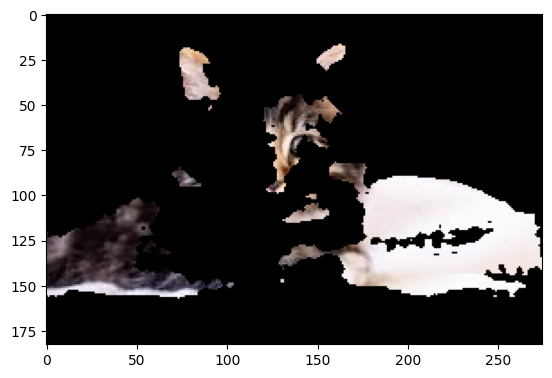

In [52]:
img_segmented=remove_backRGB_optimized(np.array(raw_image), [obj for obj in segments if obj['label']=='person'])
plt.imshow(img_segmented)
plt.show()

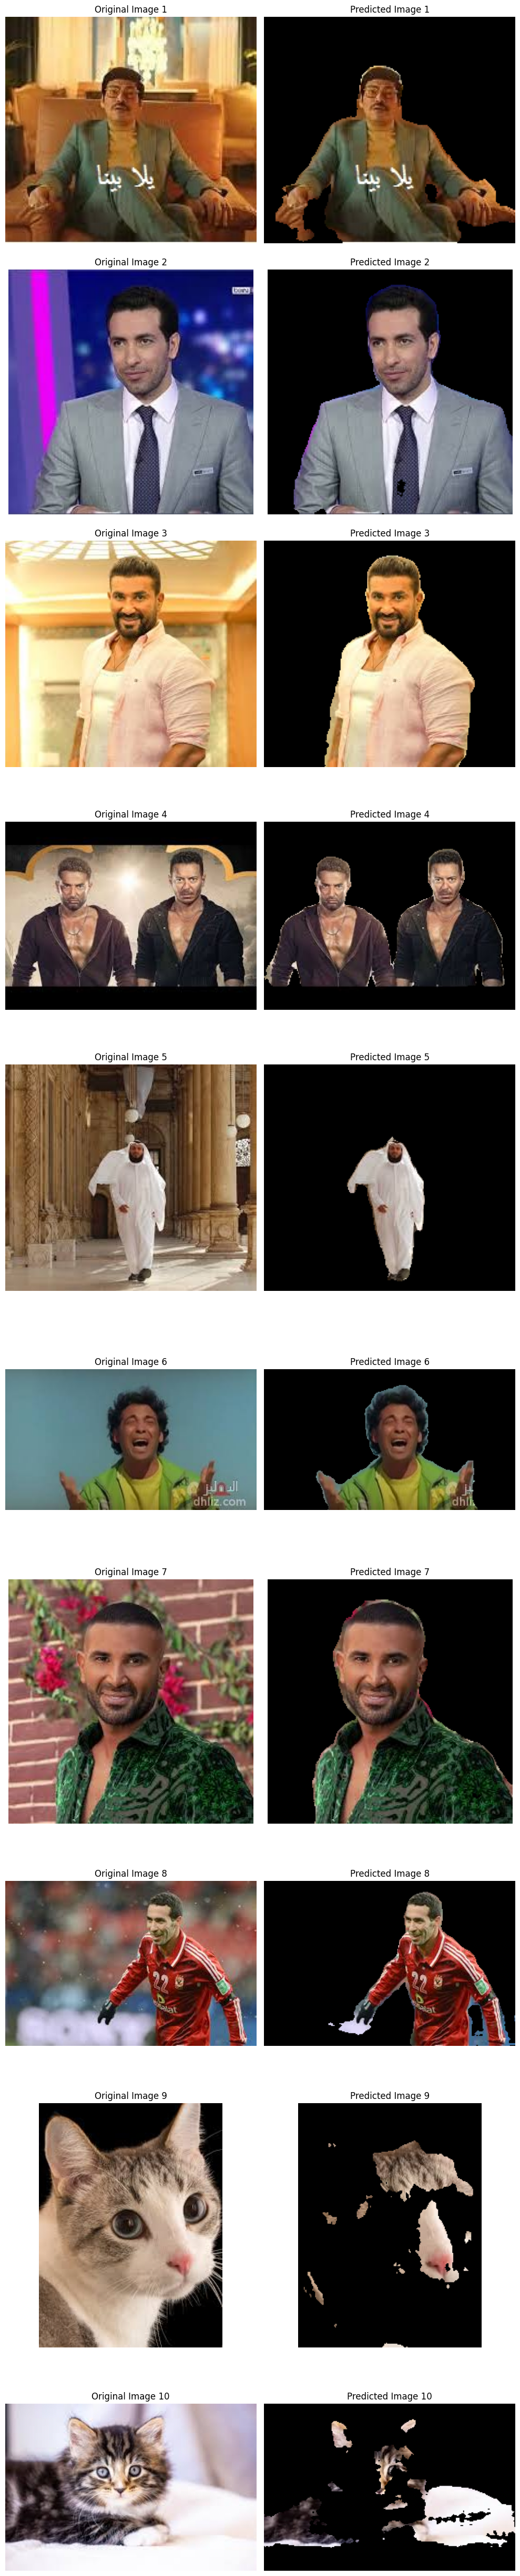

In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

images_path="./sample_data/images/"
fig, axes = plt.subplots(10, 2, figsize=(10, 10 * 5))

def get_some_images_and_inference(images_path):
    for i,img in enumerate(os.listdir(images_path)):
        image_path = os.path.join(images_path, img)
        raw_image = Image.open(image_path)
        segments = pipe(raw_image, points_per_batch=32)
        img_segmented=remove_backRGB_optimized(np.array(raw_image), [obj for obj in segments if obj['label']=='person'])

        axes[i, 0].imshow(raw_image)
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')  # Turn off axis labels

        # Plot predicted image in the second column
        axes[i, 1].imshow(img_segmented)
        axes[i, 1].set_title(f"Predicted Image {i+1}")
        axes[i, 1].axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()

get_some_images_and_inference(images_path)

In [ ]:
import os
def check_images_folder():
  if os.path.exists("./sample_data/images/"):
      return True
  else:
      return False
check_images_folder()

False

In [ ]:
!pip install ultralyticsplus==0.0.23 ultralytics==8.0.21


In [2]:
from ultralytics import YOLO
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load a model
model = YOLO("yolov8n-seg.pt")  # load an official model



c:\Users\LapStore\AppData\Local\Programs\Python\Python311\Lib\site-packages\ultralytics\nn\tasks.py:634: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file

In [2]:
img=Image.open("./pictures/10.jfif").resize((640, 480))

# Predict with the model
results = model(img)#"https://ultralytics.com/images/bus.jpg")


0: 480x640 2 persons, 52.0ms
Speed: 10.0ms preprocess, 52.0ms inference, 225.0ms postprocess per image at shape (1, 3, 480, 640)


In [6]:
class_names = model.names
len(class_names)

80

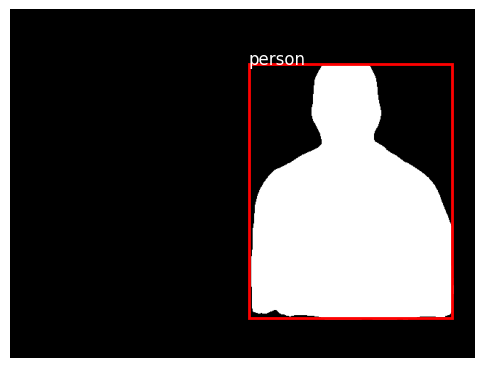

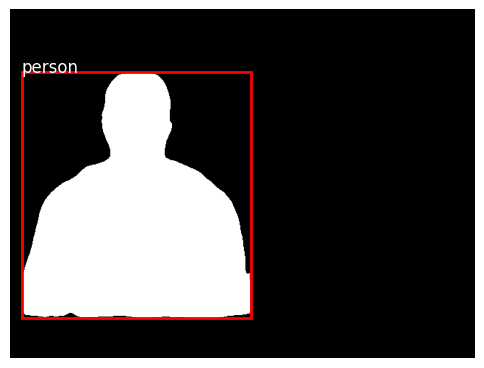

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for i, (mask, label, box) in enumerate(zip(results[0].masks.data, results[0].boxes.cls, results[0].boxes.xyxy)):
    mask_np = mask.cpu().numpy()

    # Display the mask
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_np, cmap='gray')

    # Create the bounding box
    x1, y1, x2, y2 = box.cpu().numpy()  # Ensure box coordinates are on CPU

    # Create and add the bounding box to the plot
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    # Display the label (if needed)
    label_name = class_names[int(label)]  # Ensure 'label' is on CPU if it's a tensor
    plt.text(x1, y1, label_name, color='white', fontsize=12)

    plt.axis('off')
    plt.show()

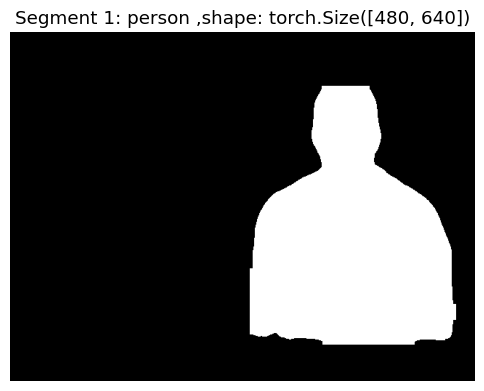

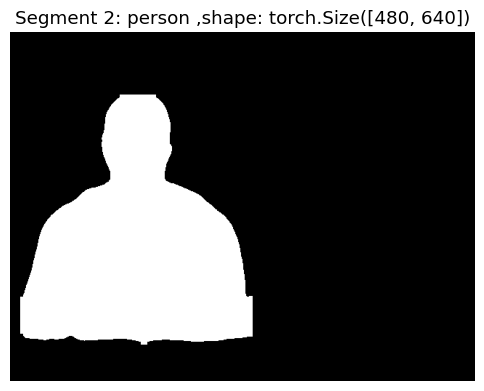

In [71]:
# Optionally, if you want to extract and display the masks:
import matplotlib.pyplot as plt
%matplotlib inline

x=mask
for i, (mask, label) in enumerate(zip(results[0].masks.data, results[0].boxes.cls)):
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    label_name = class_names[int(label)]  # get the class name for the current label
    plt.title(f'Segment {i+1}: {label_name} ,shape: {mask.shape}')
    plt.show()

In [2]:
#### target new
import PIL
from PIL import ImageDraw, ImageFont, Image ,ImageOps ,ImageFilter
import numpy as np
from ultralytics import YOLO
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# This dictionary will store names for segments across multiple inferences
segment_names = {}

def predict_image(raw_image: Image):
    model = YOLO("yolov8n-seg.pt")
    class_names = model.names
    results = model(raw_image)
    return results, class_names



def assign_segment_name(label, segment_id):
    """ Assigns a unique name for each detected segment (e.g., Person 1, Person 2). """
    if label not in segment_names:
        segment_names[label] = {}
    
    if segment_id not in segment_names[label]:
        segment_count = len(segment_names[label]) + 1
        segment_names[label][segment_id] = f"{label} {segment_count}"
    
    return segment_names[label][segment_id]


def putMaskImage(raw_image,masks,background_image="remove",blur_radius=23):
    combined_mask = np.max(masks, axis=0)

    # Create mask for areas to replace
    mask = combined_mask == True

    # Ensure the mask has the same shape as the raw image (broadcast the mask to RGB channels)
    mask_rgb = np.stack([mask] * 3, axis=-1)

    # Initialize the output array as a copy of the background image
    ##outpt = np.array(background_image.copy())
    if type(background_image)==PIL.Image.Image: # not PIL.JpegImagePlugin.JpegImageFile as resized
        outpt = np.array(background_image.copy())
    elif(background_image=="cam"):
        outpt=np.array(raw_image.filter(ImageFilter.GaussianBlur(radius=blur_radius)))
    else:#default ,say on "remove"
        outpt=np.zeros_like(raw_image)

    # Replace the background in the output image with the raw image where the mask is True
    outpt[mask_rgb] = np.array(raw_image)[mask_rgb]

    # Resize the output for better experience
    outpt = Image.fromarray(outpt)

    return outpt


def getFont():
    try:
        font = ImageFont.truetype("arial.ttf", size=20)  
    except IOError:
        font = ImageFont.load_default()
    return font

def Back_step1(raw_image: Image, background_image: Image,blur_radius=23):
    org_size = raw_image.size
    raw_image = raw_image.resize((640, 480))
    if type(background_image) == PIL.JpegImagePlugin.JpegImageFile:
        background_image = background_image.resize((640, 480))
    label_counter = []


    results, class_names = predict_image(raw_image)
    
    masks = [results[0].masks.data[i].cpu().numpy() for i in range(len(results[0].masks.data))]

    ##### put masks on image
    outpt = putMaskImage(raw_image,masks,background_image,blur_radius)
    
    # Draw bounding boxes and labels
    font=getFont()
    draw = ImageDraw.Draw(outpt) 

    
    
    for box, label, seg_id in zip(results[0].boxes.xyxy.cpu().numpy(), 
                                  results[0].boxes.cls.cpu().numpy(), 
                                  range(len(results[0].boxes))):  # segment_id for each box
        label_name = class_names[int(label)]
        
        # Assign a unique name for each detected object based on its segment
        current_label = assign_segment_name(label_name, seg_id)

        x1, y1, x2, y2 = map(int, box)
        
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        
        draw.text((x1, y1), current_label+" " + str(seg_id), fill="black", font=font)

        label_counter.append(current_label)

    return outpt.resize(org_size), label_counter


def Back_step2(raw_image:Image,background_image:Image,things_replace:list,blur_radius=23):
    org_size = raw_image.size
    raw_image = raw_image.resize((640, 480))
    print(type(background_image))
    if type(background_image)==PIL.JpegImagePlugin.JpegImageFile:
        background_image = background_image.resize((640, 480))


    results, class_names = predict_image(raw_image)
    
    masks=[]
    for segm, label,seg_id in zip(results[0].masks.data,results[0].boxes.cls.cpu().numpy(),range(len(results[0].boxes))): 
        label_name = class_names[int(label)]
        current_label = assign_segment_name(label_name, seg_id)

        if current_label in things_replace:
            masks.append(segm.cpu().numpy())

    masked_image=putMaskImage(raw_image,masks,background_image,blur_radius)
    return masked_image.resize(org_size)




In [7]:
################## trying new cleaned 

import PIL
from PIL import ImageDraw, ImageFont, Image ,ImageOps ,ImageFilter
import numpy as np
from ultralytics import YOLO
import warnings
import cv2
import numpy as np
import subprocess
import os
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

class SegmenterBackground():
    def __init__(self) -> None:
        self.segment_names = {}  # This dictionary will store names for segments across multiple inferences
        self.person=['person']
        self.animal=[ 'bird',  'cat',  'dog',  'horse', 'sheep',  'cow', 'elephant',  'bear','zebra', 'giraffe']
        self.drive=['bicycle','car','motorcycle', 'airplane', 'bus', 'train','truck','boat']

    

    def predict_image(self,raw_image: Image):
        model = YOLO("yolov8n-seg.pt")
        class_names = model.names
        results = model(raw_image)
        return results, class_names



    def assign_segment_name(self,label, segment_id):
        """ Assigns a unique name for each detected segment (e.g., Person 1, Person 2). """
        if label not in self.segment_names:
            self.segment_names[label] = {}
        
        if segment_id not in self.segment_names[label]:
            segment_count = len(self.segment_names[label]) + 1
            self.segment_names[label][segment_id] = f"{label} {segment_count}"
        
        return self.segment_names[label][segment_id]


    def putMaskImage(self,raw_image,masks,background_image="remove",blur_radius=23):
        combined_mask = np.max(masks, axis=0)

        # Create mask for areas to replace
        mask = combined_mask == True

        # Ensure the mask has the same shape as the raw image (broadcast the mask to RGB channels)
        mask_rgb = np.stack([mask] * 3, axis=-1)

        # Initialize the output array as a copy of the background image
        ##outpt = np.array(background_image.copy())
        if type(background_image)==PIL.Image.Image: # not PIL.JpegImagePlugin.JpegImageFile as resized
            outpt = np.array(background_image.copy())
        elif(background_image=="cam"):
            outpt=np.array(raw_image.filter(ImageFilter.GaussianBlur(radius=blur_radius)))
        else:#default ,say on "remove"
            outpt=np.zeros_like(raw_image)

        # Replace the background in the output image with the raw image where the mask is True
        outpt[mask_rgb] = np.array(raw_image)[mask_rgb]

        # Resize the output for better experience
        outpt = Image.fromarray(outpt)

        return outpt


    def getFont(self):
        try:
            font = ImageFont.truetype("arial.ttf", size=20)  
        except IOError:
            font = ImageFont.load_default()
        return font

    def Back_step1(self,raw_image: Image, background_image: Image,blur_radius=23):
        org_size = raw_image.size
        raw_image = raw_image.resize((640, 480))
        if type(background_image) == PIL.JpegImagePlugin.JpegImageFile:
            background_image = background_image.resize((640, 480))
        label_counter = []


        results, class_names = self.predict_image(raw_image)
        
        masks = [results[0].masks.data[i].cpu().numpy() for i in range(len(results[0].masks.data))]

        ##### put masks on image
        outpt = self.putMaskImage(raw_image,masks,background_image,blur_radius)
        
        # Draw bounding boxes and labels
        font=self.getFont()
        draw = ImageDraw.Draw(outpt) 

        
        
        for box, label, seg_id in zip(results[0].boxes.xyxy.cpu().numpy(), 
                                    results[0].boxes.cls.cpu().numpy(), 
                                    range(len(results[0].boxes))):  # segment_id for each box
            label_name = class_names[int(label)]
            
            # Assign a unique name for each detected object based on its segment
            current_label = self.assign_segment_name(label_name, seg_id)

            x1, y1, x2, y2 = map(int, box)
            
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            
            draw.text((x1, y1), current_label+" " + str(seg_id), fill="black", font=font)

            label_counter.append(current_label)

        return outpt.resize(org_size), label_counter


    def Back_step2(self,raw_image:Image,background_image:Image,things_replace:list,blur_radius=23):
        org_size = raw_image.size
        raw_image = raw_image.resize((640, 480))
        print(type(background_image))
        if type(background_image)==PIL.JpegImagePlugin.JpegImageFile:
            background_image = background_image.resize((640, 480))


        results, class_names = self.predict_image(raw_image)
        
        masks=[]
        for segm, label,seg_id in zip(results[0].masks.data,results[0].boxes.cls.cpu().numpy(),range(len(results[0].boxes))): 
            label_name = class_names[int(label)]
            current_label = self.assign_segment_name(label_name, seg_id)

            if current_label in things_replace:
                masks.append(segm.cpu().numpy())

        masked_image=self.putMaskImage(raw_image,masks,background_image,blur_radius)
        return masked_image.resize(org_size)



    def get_labels(self,kind_back):
        list_output=[]

        if ('person' in kind_back):
            list_output=list_output + self.person
        if ('animal' in kind_back):
            list_output=list_output + self.animal
        if ('drive' in kind_back):
            list_output=list_output + self.drive

        return list_output


    def Back_video_step1(self,video_path,output_path,background_image,kind_back,blur_radius=35):#background_image,what_remove,blur_radius=23): # back_image and video? #what_remove if many person it is not identify so same
        cap = cv2.VideoCapture(video_path)
        
        # Get video properties
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        #number_frames= int(cv2.CAP_PROP_FRAME_COUNT)
        
        # Define the codec and create VideoWriter object to save the output video
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
        if isinstance(background_image, Image.Image):
            background_image = background_image.resize((640, 480))

        
        sound_tmp_file='audio.mp3'
        if os.path.exists(sound_tmp_file):# to not give error
            os.remove(sound_tmp_file)
            subprocess.run(['ffmpeg', '-i', video_path, '-q:a', '0', '-map', 'a',sound_tmp_file])
        else:
            subprocess.run(['ffmpeg', '-i', video_path, '-q:a', '0', '-map', 'a',sound_tmp_file])



        i=0
        while True:

            ret, frame = cap.read()
            if not ret:
                break  # End of video
            
            # Convert the current frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = Image.fromarray(np.array(frame_rgb))
            org_size = frame_rgb.size
            frame_rgb = frame_rgb.resize((640, 480))

            results,class_names = self.predict_image(frame_rgb)

            masks=[] 
            
            things_replace=self.get_labels(kind_back)
            
            for segm, label in zip(results[0].masks.data,results[0].boxes.cls.cpu().numpy()): 
                label_name = class_names[int(label)]

                if label_name in things_replace:
                    masks.append(segm.cpu().numpy())

            masked_image = self.putMaskImage(frame_rgb,masks,background_image,blur_radius)


            out.write(cv2.cvtColor(np.array(masked_image.resize(org_size)), cv2.COLOR_RGB2BGR))

            print(f"Completed frame {i+1} ")
            i=i+1
            
            #if (i==10):
            #    break

        print("Finished frames")
        # adding original sound ,by extracting sound then put in new video

        cap.release()
        out.release()
        cv2.destroyAllWindows()
        
        
        #subprocess.run(['ffmpeg', '-i', output_path, '-i', 'audio.mp3', '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental',"temp_output_video.mp4" ])
        os.remove(sound_tmp_file)



#SegmenterBackground().Back_video_step1('./videos/2.mp4', './videos/29_sep_2.avi','cam',['animal','person'])#video,background_image,what_remove,blur_radius=23)
#subprocess.run(['ffmpeg', '-i', './videos/29_sep_2.avi', '-i', 'audio.mp3', '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental','./videos/29_sep_2.avi' ])
#os.remove(sound_tmp_file)



In [6]:
import ast
ast.literal_eval("['person']")

['person']

In [3]:
new_pic=SegmenterBackground().Back_step2(Image.open("./pictures/10.jfif"),"cam",['person 1'],23)
type(new_pic)

<class 'str'>

0: 480x640 2 persons, 50.3ms
Speed: 0.0ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


PIL.Image.Image

In [5]:
import cv2
import numpy as np
import subprocess
import os
import matplotlib.pyplot as plt

person=['person']
animal=[ 'bird',  'cat',  'dog',  'horse', 'sheep',  'cow', 'elephant',  'bear','zebra', 'giraffe']
drive=['bicycle','car','motorcycle', 'airplane', 'bus', 'train','truck','boat']

def get_labels(kind_back):
    list_output=[]

    if ('person' in kind_back):
        list_output=list_output + person
    if ('animal' in kind_back):
        list_output=list_output + animal
    if ('drive' in kind_back):
        list_output=list_output + drive

    return list_output


def Back_video_step1(video_path,output_path,background_image,kind_back,blur_radius=35):#background_image,what_remove,blur_radius=23): # back_image and video? #what_remove if many person it is not identify so same
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    #number_frames= int(cv2.CAP_PROP_FRAME_COUNT)
    
    # Define the codec and create VideoWriter object to save the output video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    if type(background_image)==PIL.JpegImagePlugin.JpegImageFile:
        background_image = background_image.resize((640, 480))

    
    sound_tmp_file='audio.mp3'
    if os.path.exists(sound_tmp_file):# to not give error
        os.remove(sound_tmp_file)
        subprocess.run(['ffmpeg', '-i', video_path, '-q:a', '0', '-map', 'a',sound_tmp_file])
    else:
        subprocess.run(['ffmpeg', '-i', video_path, '-q:a', '0', '-map', 'a',sound_tmp_file])



    i=0
    while True:

        ret, frame = cap.read()
        if not ret:
            break  # End of video
        
        # Convert the current frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_rgb = Image.fromarray(np.array(frame_rgb))
        org_size = frame_rgb.size
        frame_rgb = frame_rgb.resize((640, 480))

        results,class_names = predict_image(frame_rgb)

        masks=[] 
        
        things_replace=get_labels(kind_back)
        
        for segm, label in zip(results[0].masks.data,results[0].boxes.cls.cpu().numpy()): 
            label_name = class_names[int(label)]

            if label_name in things_replace:
                masks.append(segm.cpu().numpy())

        masked_image = putMaskImage(frame_rgb,masks,background_image,blur_radius)
        #return masked_image.resize(org_size)


        out.write(cv2.cvtColor(np.array(masked_image.resize(org_size)), cv2.COLOR_RGB2BGR))

        print(f"Completed frame {i+1} ")
        i=i+1
        
        #if (i==10):
        #    break

    print("Finished frames")
    # adding original sound ,by extracting sound then put in new video

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    #import time
    #time.sleep(1)
    subprocess.run(['ffmpeg', '-i', output_path, '-i', 'audio.mp3', '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental',"temp_output_video.mp4" ])
    os.remove(sound_tmp_file)

    # Release everything
    
    #cv2.destroyAllWindows()


Back_video_step1('./videos/2.mp4', './videos/29_sep_2.avi','cam',['animal','person'])#video,background_image,what_remove,blur_radius=23)
subprocess.run(['ffmpeg', '-i', './videos/29_sep_2.avi', '-i', 'audio.mp3', '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental','./videos/29_sep_2.avi' ])
#os.remove(sound_tmp_file)


0: 480x640 2 persons, 1 broccoli, 49.9ms
Speed: 6.5ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


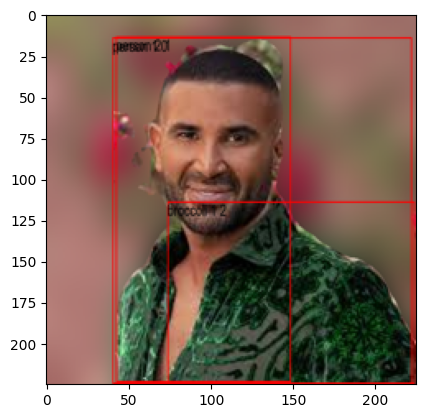

In [9]:
new_pic=SegmenterBackground().Back_step1(Image.open("./pictures/1.jfif"),"cam",23)#Image.open("./pictures/backgrounds/1.jfif"))
plt.imshow(new_pic[0])
plt.show()

In [16]:
ast.literal_eval("['person']")=['']

list

<class 'str'>

0: 480x640 2 persons, 50.4ms
Speed: 0.0ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


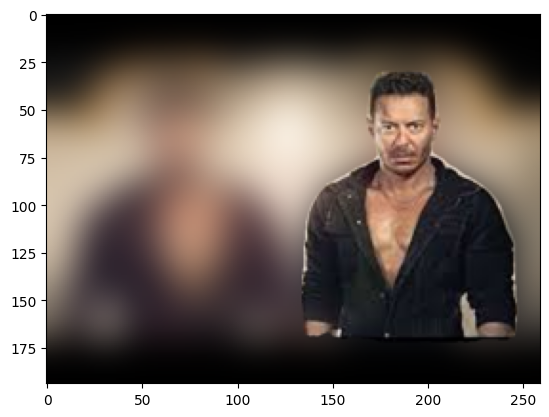

In [17]:
import ast
s=ast.literal_eval("['person 1']")
new_pic=SegmenterBackground().Back_step2(Image.open("./pictures/10.jfif"),"cam",s,23)
plt.imshow(new_pic)
plt.show()

In [20]:
new_pic[1]

['person 1', 'person 2']

In [24]:
## decode 64encoded image
from PIL import Image
import io
import base64

img_data = base64.b64decode(encoded_img)

# Convert the binary data back into an image using BytesIO
image = Image.open(io.BytesIO(img_data))

image.show()  # -------> This will open the image in your default viewer
